# **SIADS Milestone I - Sentiment Analysis of TikTok Video**

- **Cydia Tsang (cydia@umich.edu)**, School of Information, University of Michigan
- **Yao Tong (tonyao@umich.edu)**, School of Information, University of Michigan



#### **Strcuture of the Code:**

&emsp; **Data Import**<br>
&emsp;&emsp;&emsp; 1. Primary Dataset - trending.json<br>
&emsp;&emsp;&emsp; 2. Seconndary Dataset - audd_music.csv<br>
&emsp;&emsp;&emsp; 3. Thrid Dataset - audd_music_apple_music.csv<br>
&emsp; **Data Cleaning & Manipulation**<br>
&emsp;&emsp;&emsp; 1. Basic Desciptive Statistic Data Manipulation<br>
&emsp;&emsp;&emsp; 2. Music Related Data Manipulation<br>
&emsp;&emsp;&emsp; 3. Author Related Data Manipulation<br>
&emsp;&emsp;&emsp; 4. Video Related Data Manipulation<br>
&emsp;&emsp;&emsp; 5. Test Related Data Manipulation<br>
&emsp; **Data Analysis & Visualisation**<br>
&emsp;&emsp;&emsp; 1. Basic Desciptive Statistic Analysis<br>
&emsp;&emsp;&emsp; 2. Music Related Analysis<br>
&emsp;&emsp;&emsp; 3. Author Related Analysis<br>
&emsp;&emsp;&emsp; 4. Video Related Analysis<br>
&emsp;&emsp;&emsp; 5. Test Related Analysis<br>

In [1]:
import sys, os
import json
import ast
import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn.preprocessing import MinMaxScaler
from wordcloud import WordCloud
import itertools
import nltk
from nltk.probability import FreqDist, ConditionalFreqDist
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy.stats import pearsonr
from boto3.dynamodb.types import TypeDeserializer
sys.path.append(os.getcwd() + "/src")
from src.pj_config.dynamo_db_client import get_dynamo_db_client
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from decimal import Decimal
from collections import Counter
plt.rcParams['font.family'] = 'Arial Unicode MS'

# **Data Import**

The trending.json was initially imported into DynamoDB and retrived by the scan() method from boto3.

The following code aims to convert a response from a DynamoDB scan operation into a Pandas DataFrame. Initially, it retrieves items from the DynamoDB table 'tiktok_trending' using the scan operation. To handle cases where the result spans multiple pages, it iterates through each page, continuously appending the retrieved items.

The convert_dynamodb_response function plays a crucial role in converting the raw DynamoDB response into a DataFrame. It first defines a deserializer to handle data types, then parses each item in the response to convert it into a dictionary. This dictionary comprehension ensures that the data is deserialized appropriately. Subsequently, any dictionary values are further processed to extract their string representations. Finally, these processed items are converted into a DataFrame, providing a structured representation of the DynamoDB data suitable for analysis and manipulation in Python.

### **1. Primary Dataset - trending.json**

In [2]:
def convert_dynamodb_response(response):
    deserializer = TypeDeserializer()
    def parse_item(item):
        return {key: deserializer.deserialize(value) for key, value in item.items()}
  
    items_temp = [parse_item(item) for item in items]
    df = pd.DataFrame(items_temp)
    df = df.applymap(lambda x: x if not isinstance(x, dict) else x.get('S', x))
    return df
    
dynamodb = get_dynamo_db_client()
response = dynamodb.scan(TableName='tiktok_trending')

items=response["Items"]

while 'LastEvaluatedKey' in response and response['LastEvaluatedKey'] != "":  
    response = dynamodb.scan(TableName='tiktok_trending', ExclusiveStartKey=response['LastEvaluatedKey'])
    items.extend(response["Items"])
df = convert_dynamodb_response(items)


### **2. Seconndary Dataset - audd_music.csv**

In [3]:
audd_music_df = pd.read_csv(
    'src/data/audd/audd_music.csv',
    sep=',',  # Specify the delimiter if it's not a comma
    skiprows=1,  # Skip rows if necessary (e.g., skip the first row)
    names=['id', 'artist', 'title','album','release_data','label','timecode','song_link','apple_music.isrc','spotify.id'],  
    encoding='utf-8'  # Specify the encoding if there are special characters
)

### **3. Third Dataset - audd_music_apple_music.csv**

In [4]:
audd_apple_music_df = pd.read_csv(
    'src/data/audd/audd_music_apple_music.csv',
    sep=',',  # Specify the delimiter if it's not a comma
    skiprows=1,  # Skip rows if necessary (e.g., skip the first row)
    names=['isrc', 'artistName', 'url', 'discNumber', 'genreNames',
       'durationInMillis', 'releaseDate', 'name', 'albumName', 'trackNumber',
       'composerName', 'artwork.width', 'artwork.height', 'artwork.url',
       'artwork.bgColor', 'artwork.textColor1', 'artwork.textColor2',
       'artwork.textColor3', 'artwork.textColor4', 'playParams.id',
       'playParams.kind'],  
    encoding='utf-8'  # Specify the encoding if there are special characters
)

# **Data Cleaning & Manipulation**
The part encompasses several data preprocessing steps commonly encountered in exploratory data analysis (EDA) tasks, primarily focusing on structuring data extracted from the TikTok platform for subsequent analysis.

Firstly, it performs basic data preprocessing, including the conversion of specified columns to numeric types and the removal of outliers based on the interquartile range (IQR) method. Subsequently, the code segments the dataset into four distinct categories: user, music, video, and text, each tailored to the nature of the features they encapsulate.

For user-related data, it involves extracting pertinent information about TikTok authors and restructuring it for clarity and ease of analysis. Similarly, for music-related data, it involves processing music metadata and merging it with external data from the AuDD platform, facilitating comprehensive insights into the music used in TikTok content. Video data undergoes a transformation to extract key attributes such as width, duration, and height from the video metadata. Lastly, text-related data are structured to include relevant hashtag information and categorize various engagement metrics into discrete categories.

By segmenting and preprocessing the TikTok dataset into these distinct categories, the code lays the groundwork for subsequent analysis, enabling researchers and analysts to delve deeper into specific aspects of TikTok content and user engagement.

### **1. Basic Desciptive Statistic Data Manipulation**

In [5]:
###### Basic
                          
df = df.copy()
numeric_columns = ['diggCount', 'commentCount', 'shareCount', 'playCount']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

Q1 = df[numeric_columns].quantile(0.05)
Q3 = df[numeric_columns].quantile(0.80)
IQR = Q3 - Q1

def remove_outliers(df):
    return df[~((df[numeric_columns] < (Q1 - 1.5 * IQR)) | (df[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]
    
df = remove_outliers(df)

basic_df = df[['id', 'createTime', 'diggCount', 'commentCount', 'shareCount', 'playCount']]

### **2. Music Related Data Manipulation**

In [6]:
###### Music
merged_music_df = pd.merge(audd_music_df, audd_apple_music_df, left_on='apple_music.isrc', right_on='isrc', how='inner')
final_music_df = merged_music_df[['id', 'label', 'timecode', 'genreNames', 'releaseDate']]
final_music_df = final_music_df.dropna()

In [7]:
music_df = df[['id', 'createTime', 'musicMeta', 'diggCount', 'commentCount', 'shareCount', 'playCount', 'downloaded', 'text', 'hashtags']]
music_df = music_df.copy()
music_df['musicMeta'] = music_df['musicMeta'].apply(lambda x: {
    'musicId': x['musicId'],
    'musicAuthor': x['musicAuthor'],
    'musicName': x['musicName'],
    'musicOriginal': x['musicOriginal'],
    'playUrl': x['playUrl']
})
music_df[['musicId', 'musicAuthor', 'musicName', 'musicOriginal', 'playUrl']] = pd.DataFrame(music_df['musicMeta'].tolist())
music_df.drop(columns=['musicMeta'], inplace=True)
music_df = music_df.dropna()

### **3. Author Related Data Manipulation**

In [8]:
###### User
authors_df = df[['id', 'createTime', 'authorMeta', 'diggCount', 'commentCount', 'shareCount', 'playCount', 'downloaded']]
authors_df = authors_df.copy()
authors_df['authorMeta'] = authors_df['authorMeta'].apply(lambda x: {'secUid': x['secUid'], 
                                                               'signature': x['signature'], 
                                                               'nickName': x['nickName'], 
                                                               'name': x['name'], 
                                                               'verified': x['verified'], 
                                                               'id': x['id'], 
                                                               'avatar': x['avatar']})

authors_df[['secUid', 'signature', 'nickName', 'name', 'verified', 'id', 'avatar']] = pd.DataFrame(authors_df['authorMeta'].tolist())
authors_df = authors_df.dropna()

### **4. Video Related Data Manipulation**

In [9]:
###### Video
video_df = df[['id', 'createTime', 'videoMeta', 'diggCount', 'commentCount', 'shareCount', 'playCount', 'downloaded']]
video_df = video_df.copy()

# Extract videoMeta into 3 fields(video_width, video_duration and video_height)
video_df['videoMeta'] = video_df['videoMeta'].apply(lambda x: {'width': int(x['width']), 'duration': int(x['duration']), 'height': int(x['height'])})
video_df[['video_width', 'video_duration', 'video_height']] = pd.DataFrame(video_df['videoMeta'].tolist())

video_df = video_df.dropna()

### **5. Text Related Data Manipulation**

In [10]:
###### Text
text_df = df[['id', 'createTime', 'hashtags', 'mentions', 'diggCount', 'commentCount', 'shareCount', 'playCount', 'downloaded']]

categories = ['diggCountCategory', 'shareCountCategory', 'playCountCategory', 'commentCountCategory']
target_values = ['very low', 'low', 'medium', 'high', 'very high']

# Divided diggCount, commentCount, shareCount and playCount into 'very low', 'low', 'medium', 'high', 'very high' 5 catagories
def process_numeric_column(df, column_name):
    df_copy = df.copy()
    quantiles = df_copy[column_name].quantile([0, 1/5, 2/5, 3/5, 4/5, 1])
    df_copy[f'{column_name}Category'] = pd.cut(df_copy[column_name], bins=quantiles, labels=target_values, include_lowest=True)
    return df_copy

text_df = process_numeric_column(text_df, 'diggCount')
text_df = process_numeric_column(text_df, 'commentCount')
text_df = process_numeric_column(text_df, 'shareCount')
text_df = process_numeric_column(text_df, 'playCount')

text_df['hashtag'] = text_df['hashtags'].apply(lambda x: [item['name'] for item in x] if x else [])
text_df = text_df.explode('hashtag').reset_index(drop=True)
text_df = text_df[['id', 'createTime', 'hashtag', 'diggCount', 'commentCount', 'shareCount', 'playCount','diggCountCategory', 'shareCountCategory', 'playCountCategory', 'commentCountCategory']]
text_df = text_df.dropna()

# **Data Analysis & Visualisation**
This part will cover the data analysis and visualization pipeline covering various domains such as music, video, and text. Let's break down each section and understand its purpose and what insights can be derived from the visualizations.

### **1. Basic Desciptive Statistic**

Descriptive Statistics:
          diggCount  commentCount   shareCount      playCount
count    827.000000    827.000000   827.000000     827.000000
mean    9705.031439    175.051995   162.212817  104355.544135
std    11624.474699    217.013570   263.386790  107889.272489
min       13.000000      0.000000     0.000000     465.000000
25%     2201.000000     37.000000    15.000000   41750.000000
50%     5534.000000     91.000000    53.000000   67100.000000
75%    12400.000000    219.500000   176.000000  126200.000000
max    73300.000000   1238.000000  1508.000000  762500.000000


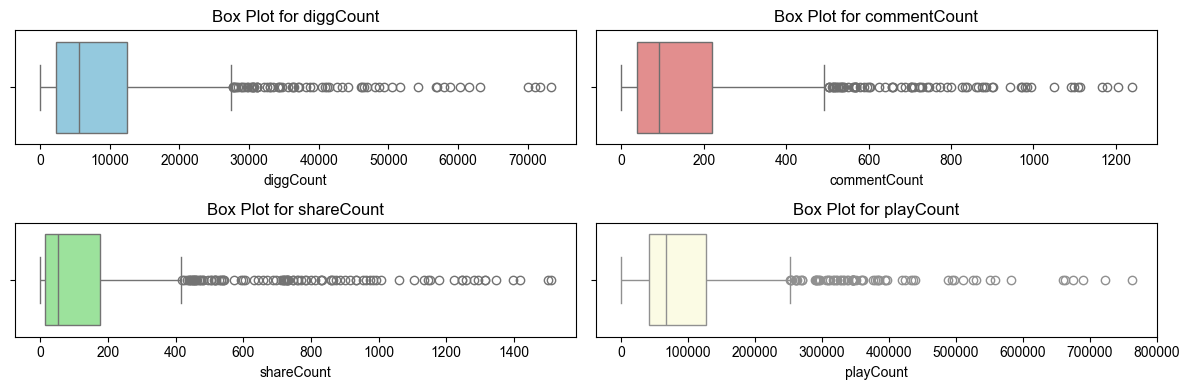

In [11]:
###### Basic
descriptive_stats = basic_df[['diggCount', 'commentCount', 'shareCount', 'playCount']].describe()

print("Descriptive Statistics:")
print(descriptive_stats)

plt.figure(figsize=(12, 4))
colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightyellow']
for i, (col, color) in enumerate(zip(numeric_columns, colors), 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=basic_df[col], color=color)
    plt.title(f'Box Plot for {col}')

plt.tight_layout()
plt.show()

### **2. Music Related Analysis**

Timecode in TikTok's musicMeta typically refers to the specific timestamp or point in the background music track from which the music starts playing in the video.
For the analysis of music, we selected the Timecode of the background music based on the top trending videos as the main clue to try to analyze the music pattern preferred by trending videos and analyze the sentiment of the music and video text. In descriptive data, the timecodes used by different music genres are distinguished, but the commonly used timecodes are concentrated around 50s of a song. 

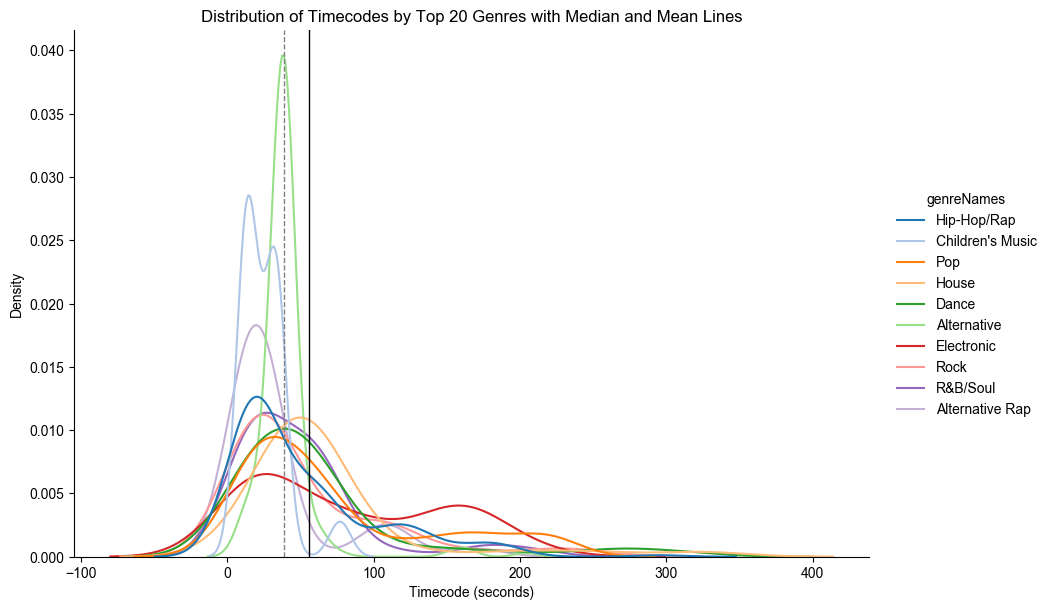

In [13]:
final_music_df['genreNames'] = final_music_df['genreNames'].apply(lambda x: str(x) if not isinstance(x, str) else x)
final_music_df['genreNames'] = final_music_df['genreNames'].apply(ast.literal_eval)
all_genres = [genre for sublist in final_music_df['genreNames'] for genre in sublist if genre != 'Music']
genre_counts = Counter(all_genres)
genre_counts_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count'])

exploded_df = final_music_df.explode('genreNames')
exploded_df = exploded_df[exploded_df['genreNames'] != 'Music']

def timecode_to_seconds(timecode):
    # Split the timecode into minutes and seconds
    minutes, seconds = map(int, timecode.split(':'))
    # Convert the timecode to total seconds
    return minutes * 60 + seconds

# Apply the conversion function to each timecode
exploded_df['timecode'] = exploded_df['timecode'].apply(timecode_to_seconds)

# Combine median and mean timecodes into a single DataFrame
top_10_genres = genre_counts_df.nlargest(10, 'Count')['Genre']

# Step 2: Filter 'exploded_df' to include only the top 10 genres
filtered_df = exploded_df[exploded_df['genreNames'].isin(top_10_genres)]


# Create a displot for the top 10 genres
g = sns.displot(
    data=filtered_df,
    x='timecode',
    hue='genreNames',
    kind='kde',
    height=6, aspect=1.5,
    palette='tab20',
    common_norm=False,
    facet_kws={'legend_out': True}
)

# Calculate the global median and mean timecode across all top 10 genres
global_median = filtered_df['timecode'].median()
global_mean = filtered_df['timecode'].mean()

# Add lines for global median and mean timecodes
plt.axvline(global_median, color='grey', linestyle='--', linewidth=1, label='Global Median')
plt.axvline(global_mean, color='black', linestyle='-', linewidth=1, label='Global Mean')

# Create custom legend handles
median_line = plt.Line2D([], [], color='grey', linestyle='--', linewidth=2, label='Global Median')
mean_line = plt.Line2D([], [], color='grey', linestyle='-', linewidth=2, label='Global Mean')

# Add the custom legend with the original legend
#plt.legend(handles=g._legend.legendHandles + [median_line, mean_line], bbox_to_anchor=(1.05, 1), loc=2)

plt.title('Distribution of Timecodes by Top 20 Genres with Median and Mean Lines')
plt.xlabel('Timecode (seconds)')
plt.ylabel('Density')
plt.show()

In [17]:
#To install, use !pip install vaderSentiment
# Initialize VADER sentiment analyzer
exploded_df = exploded_df.rename(columns={'id': 'musicId'})
music_df['musicId'] = music_df['musicId'].astype(int)
merged_df = pd.merge(music_df, exploded_df, left_on='musicId', right_on='musicId', how='left')
analyzer = SentimentIntensityAnalyzer()

# Function to clean text data
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and digits
    text = re.sub(r'[^A-Za-z\s]+', '', text)
    return text

# Apply the cleaning function to the text column
merged_df['text'] = merged_df['text'].apply(clean_text)
merged_df['sentiment_score'] = merged_df['text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
merged_df.head()

,id,createTime,diggCount,commentCount,shareCount,playCount,downloaded,text,hashtags,musicId,musicAuthor,musicName,musicOriginal,playUrl,label,timecode,genreNames,releaseDate,sentiment_score
0,6904256013650758914,1607522373,22100.0,179.0,228.0,253000.0,True,Storytime vjp voorjou fyp foryou dutch tiktokn...,"[{'name': 'vjp', 'cover': '', 'id': '30368892'...",6894455749469129477,Grace Groski,original sound,True,https://sf77-sg.tiktokcdn.com/obj/musically-ma...,NaN,NaN,NaN,NaN,0.0000
1,6907464609116982529,1608269434,25200.0,984.0,194.0,439700.0,True,kesfet turkish asianmakeup foryou viral voorjo...,"[{'name': 'kesfet', 'cover': '', 'id': '715598...",6902010365777840901,user7832472351324,original sound,True,https://sf16-sign-va.tiktokcdn.com/musically-m...,NaN,NaN,NaN,NaN,0.6597
2,6903994055907118338,1607461382,1339.0,26.0,31.0,28200.0,True,Its always the most difficult workout,[],6783518343648348933,Jake,Thank you all for using my sound,True,https://sf77-sg.tiktokcdn.com/obj/musically-ma...,Universal Music,134.0,Hip-Hop/Rap,2017-05-05,-0.4201
3,6903994055907118338,1607461382,1339.0,26.0,31.0,28200.0,True,Its always the most difficult workout,[],6783518343648348933,Jake,Thank you all for using my sound,True,https://sf77-sg.tiktokcdn.com/obj/musically-ma...,Universal Music,134.0,Hip-Hop/Rap,2017-05-05,-0.4201
4,6903994055907118338,1607461382,1339.0,26.0,31.0,28200.0,True,Its always the most difficult workout,[],6783518343648348933,Jake,Thank you all for using my sound,True,https://sf77-sg.tiktokcdn.com/obj/musically-ma...,Universal Music,134.0,Hip-Hop/Rap,2017-05-05,-0.4201


#### Explanation about the sentiment_score:
High Score (Close to 1)
A high sentiment score, approaching 1, usually indicates a strong positive sentiment. Texts with high scores are likely to contain positive expressions, praising comments, or optimistic language. For instance, phrases like "absolutely fantastic", "incredibly happy", or "best experience ever" would contribute to a high sentiment score.

Low Score (Close to -1)
A low sentiment score, approaching -1, suggests a strong negative sentiment. This means the text likely includes criticisms, expressions of dissatisfaction, sadness, or anger. Examples of phrases that might result in a low sentiment score include "terribly disappointed", "worst service", or "deeply saddened".

Score Around Zero
Sentiment scores close to 0 can indicate neutral sentiment, where the text might be factual, lack emotional language, or contain an equal mix of positive and negative sentiments that balance each other out. Neutral texts might include factual statements like "The conference starts at 9 AM" or mixed sentiment expressions like "I love the camera on this phone, but the battery life is disappointing".

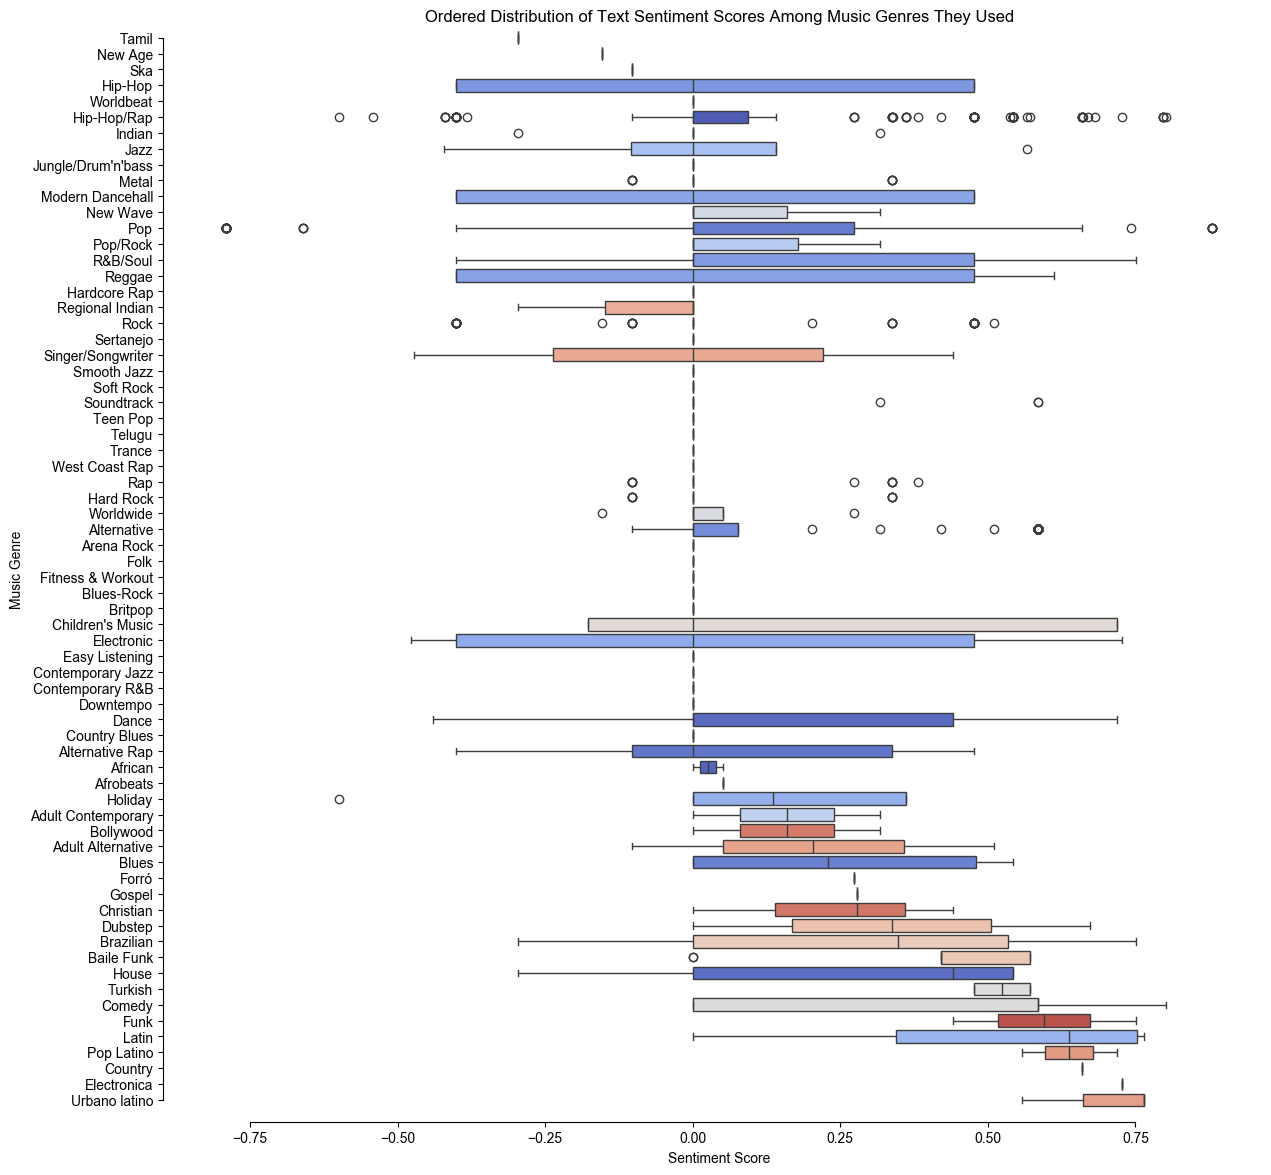

In [18]:
genre_median_scores = merged_df.groupby('genreNames')['sentiment_score'].median().sort_values()

ordered_genres = genre_median_scores.index
#Create a box plot with ordered genres
plt.figure(figsize=(14, 14))
sns.boxplot(data=merged_df, x='sentiment_score', y='genreNames', hue='genreNames', order=ordered_genres, palette="coolwarm", legend=False)

# Increase separation between boxes for clarity
sns.despine(offset=10, trim=True)

plt.title('Ordered Distribution of Text Sentiment Scores Among Music Genres They Used')
plt.xlabel('Sentiment Score')
plt.ylabel('Music Genre')
plt.show()

### **3. Author Related Analysis**

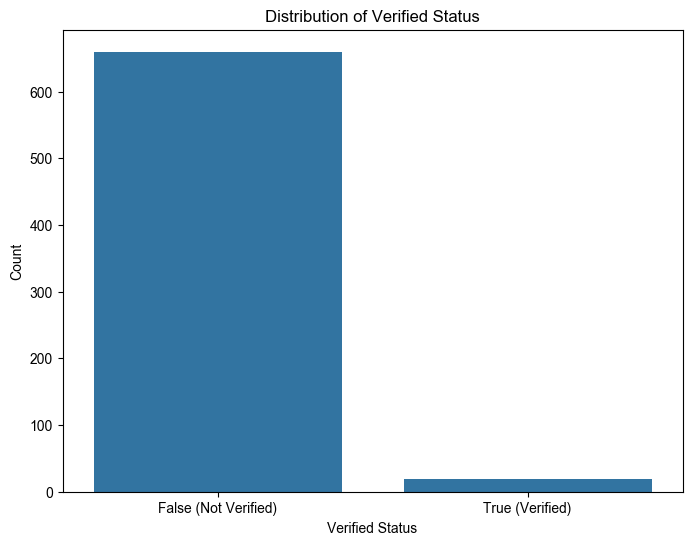

In [19]:
verified_counts = authors_df['verified'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=verified_counts.index.astype(str), y=verified_counts.values)  # Convert index to string for clarity

plt.title('Distribution of Verified Status')
plt.xlabel('Verified Status')
plt.ylabel('Count')
# Dynamically set x-tick labels based on the order in verified_counts
plt.xticks([0, 1], [f'{verified_counts.index[0]} (Not Verified)', f'{verified_counts.index[1]} (Verified)'])

plt.show()

authors_df = authors_df.rename(columns={'id': 'authors_id'})
combined_df = pd.concat([authors_df, merged_music_df], axis=1)

### **4. Video Related Analysis**

This section computes and displays the correlation coefficient between the duration of videos and various engagement metrics such as diggCount, shareCount, playCount, and commentCount. It will then fit a linear regression model to predict video duration based on engagement metrics and evaluates its performance using R-squared.The coefficients of the model are displayed, indicating the relative importance of each engagement metric in predicting video duration.

In [20]:
###### Video
def correlation_analysis(column_name):
    correlation_coefficient, _ = pearsonr(video_df['video_duration'], video_df[column_name])
    return correlation_coefficient

variables_to_compare = ['diggCount', 'shareCount', 'playCount', 'commentCount']

print("Correlation Coefficient between video_duration and Calculated by pearsonr:")
# Compute and print correlation coefficients
for variable in variables_to_compare:
    correlation_coefficient = correlation_analysis(variable)
    print(f"Correlation Coefficient (video_duration vs {variable}): {correlation_coefficient}")

X = video_df[['diggCount', 'shareCount', 'playCount', 'commentCount']]
y = video_df['video_duration']
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")
print(f"R-squared: {metrics.r2_score(y_test, y_pred)}")
print(f"P-values: {model.coef_}")


Correlation Coefficient between video_duration and Calculated by pearsonr:
Correlation Coefficient (video_duration vs diggCount): 0.04328252676930378
Correlation Coefficient (video_duration vs shareCount): 0.06149484100612049
Correlation Coefficient (video_duration vs playCount): -0.01679653383827796
Correlation Coefficient (video_duration vs commentCount): 0.07684411112697243
Coefficients: [  4.86543998   6.11768616 -11.58879549   3.44878285]
Intercept: 18.52029718669578
R-squared: -0.003941415612633836
P-values: [  4.86543998   6.11768616 -11.58879549   3.44878285]


This scatter plots visualize the relationship between video duration and each engagement metric, providing insights into how video length influences engagement.

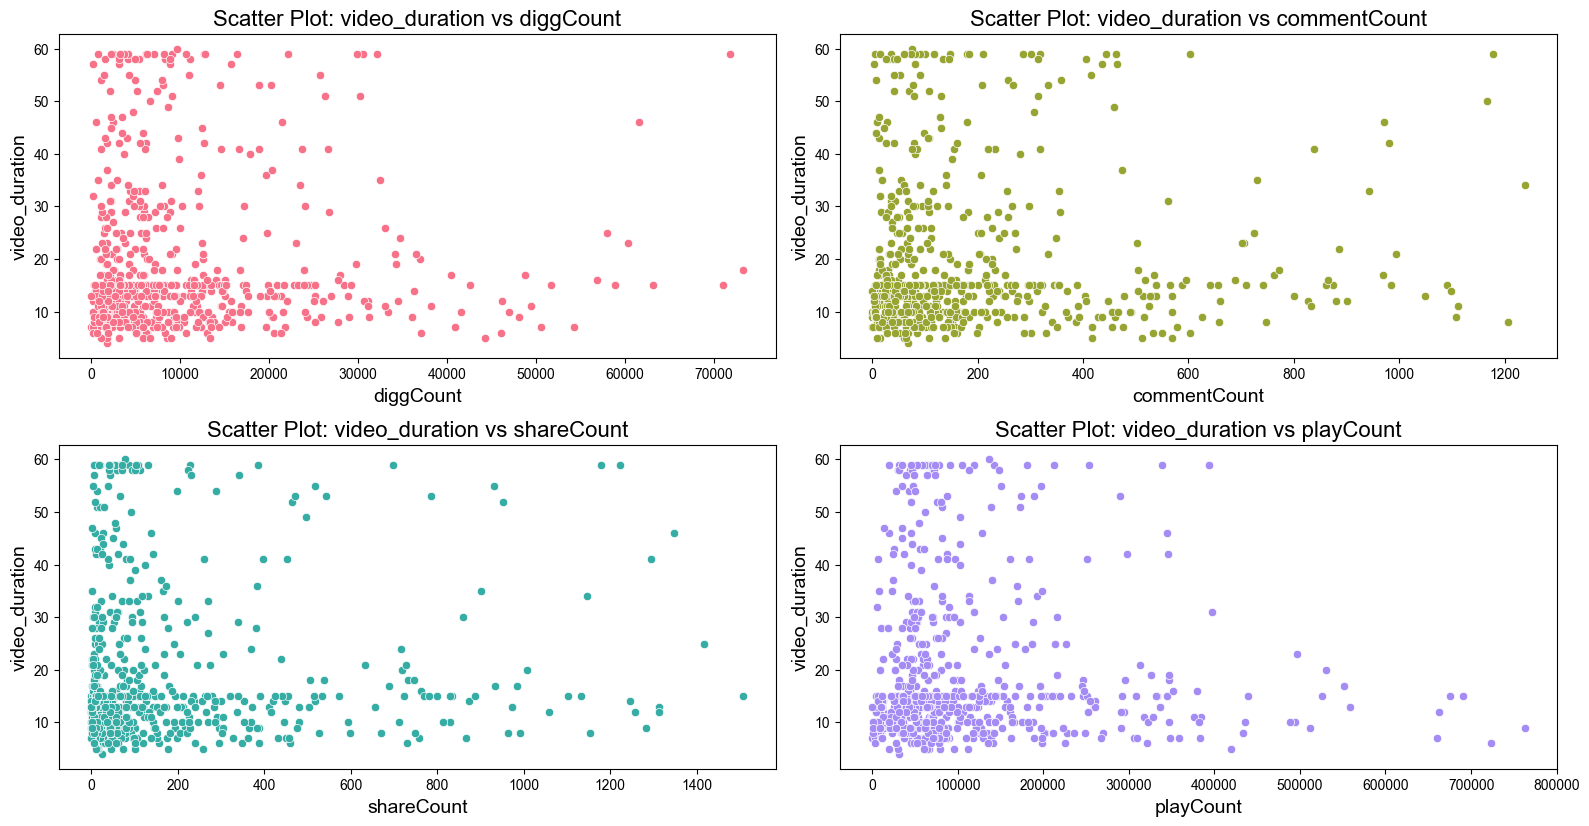

In [21]:
num_cols = ["diggCount", "commentCount", "shareCount", "playCount"]
colors = sns.color_palette('husl', len(num_cols))

plt.figure(figsize=(16, 12))

for i, col in enumerate(num_cols, start=1):
    plt.subplot(3, 2, i)
    sns.scatterplot(x=col, y='video_duration', data=video_df, color=colors[i-1])
    plt.title(f'Scatter Plot: video_duration vs {col}', fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('video_duration', fontsize=14) 
    
plt.tight_layout()
plt.show()

This heatmap visualizes the correlation matrix between video duration and engagement metrics, offering a comprehensive view of their relationships.

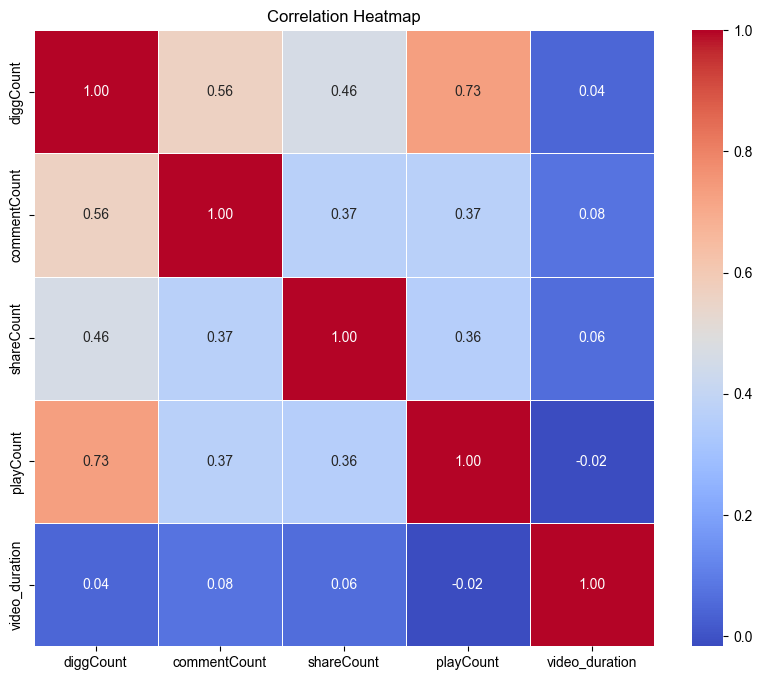

In [22]:
# Correlation heatmap
video_new_df = video_df[["diggCount", "commentCount", "shareCount", "playCount", "video_duration"]]
plt.figure(figsize=(10, 8))
correlation_matrix = video_new_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

### **5. Text Related Analysis**

This part calculates the probability distribution of hashtag categories (e.g., diggCountCategory, shareCountCategory) based on engagement counts. It identifies hashtags with very high and very low engagement counts within each category.

In [23]:
###### Text
def calculate_probability(text_df, count, category):
    text_df = text_df[['hashtag', count, category]].sort_values(by='hashtag')

    # Group the data by hashtag and category
    group_text_df = text_df.groupby(['hashtag', category]).size().reset_index(name='count')
    total_count_per_hashtag = text_df.groupby(['hashtag', category])[count].mean().reset_index(name='mean_' + count)
    merged_df = pd.merge(group_text_df, total_count_per_hashtag, on=['hashtag', category])

    # The probaility of 'very low', 'low', 'medium', 'high', 'very high' over total number of catagory
    merged_df['probability'] = merged_df.groupby('hashtag')['count'].transform(lambda x: x / x.sum())
    
    # Filter out records that have more than 1 occuring and > 0.5 probability of each catagory over total cattagory
    filtered_text_df = merged_df[(merged_df['count'] > 1) & (merged_df['probability'] > 0.5)]
    
    text_very_high_df = filtered_text_df[filtered_text_df[category] == 'very high']
    text_very_low_df = filtered_text_df[filtered_text_df[category] == 'very low']
    return text_df, text_very_high_df.head(10), text_very_low_df.head(10)

digg_count_cat_df, digg_count_cat_very_high, digg_count_cat_very_low = calculate_probability(text_df, 'diggCount', 'diggCountCategory')
share_count_cat_df, share_count_cat_very_high, share_count_cat_very_low = calculate_probability(text_df, 'shareCount', 'shareCountCategory')
play_count_cat_df, play_count_cat_very_high, play_count_cat_very_low = calculate_probability(text_df, 'playCount', 'playCountCategory')
comment_count_cat_df, comment_count_cat_very_high, comment_count_cat_very_low = calculate_probability(text_df, 'commentCount', 'commentCountCategory')

a word cloud visualizes the most frequent hashtags, providing insights into popular topics or themes.

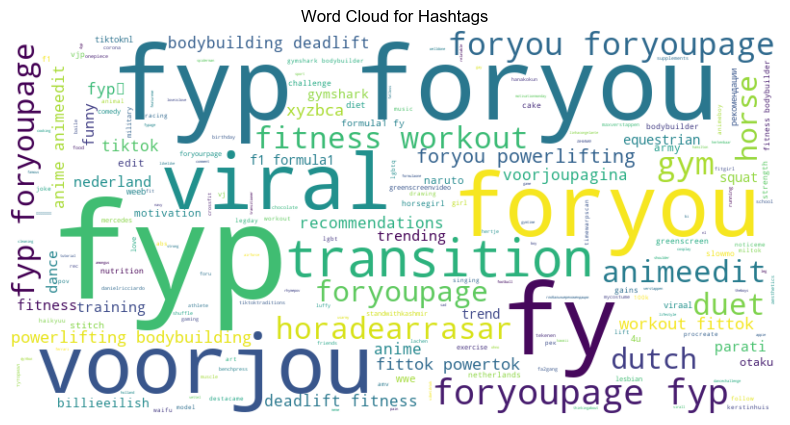

In [24]:
all_hashtags = ' '.join(text_df['hashtag'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_hashtags)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Hashtags')
plt.show()

These Bar charts showcase the top hashtags with very high engagement counts for each category, allowing for a deeper understanding of popular topics on the platform.

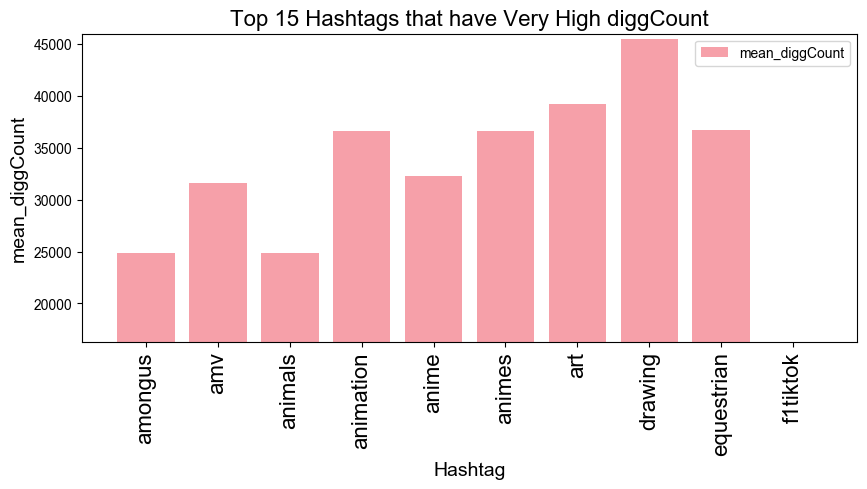

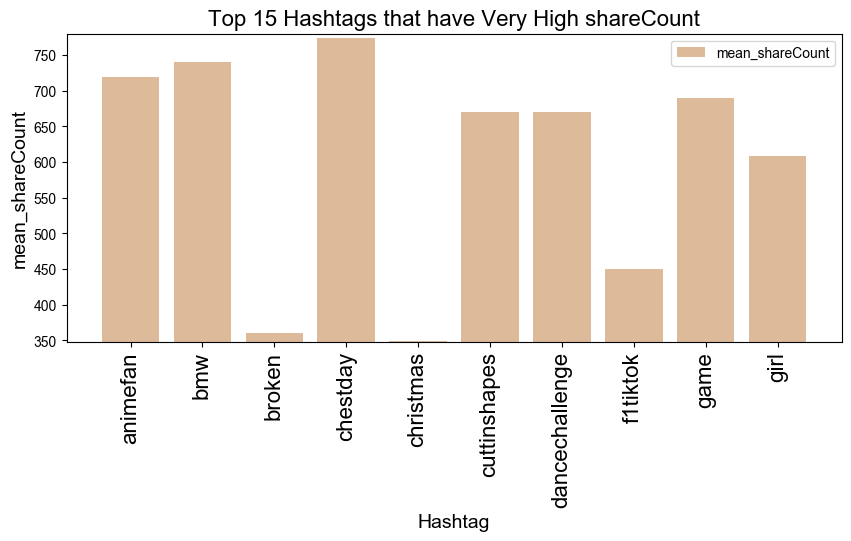

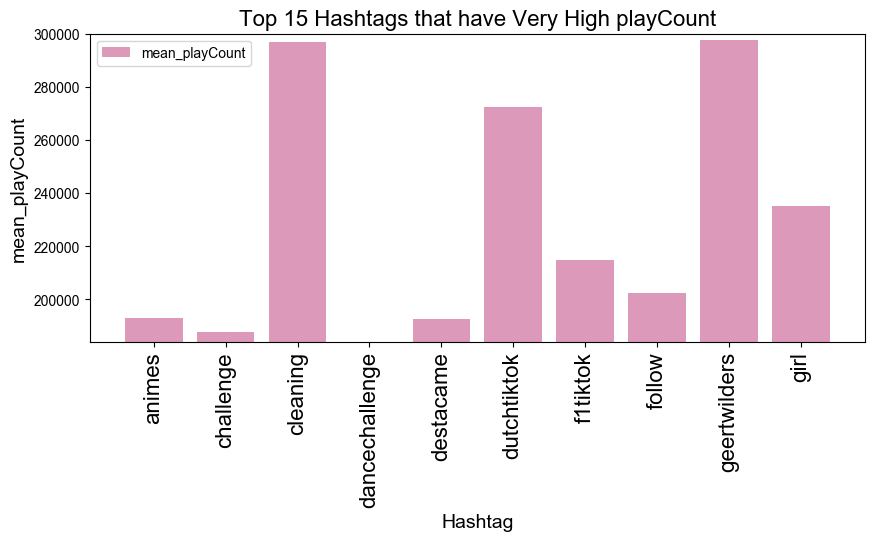

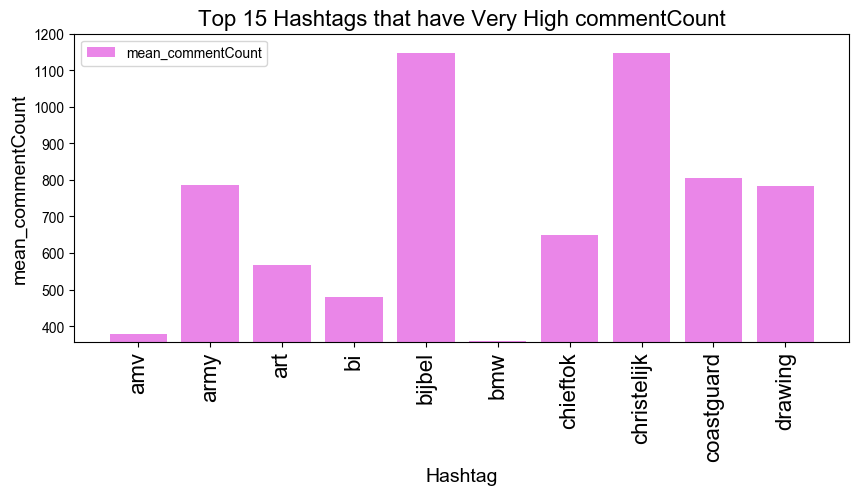

In [25]:

def getBarChart(df, mean_count, count_name, min_val, max_val, color='blue'):
    fig, ax = plt.subplots(figsize=(10, 4))
    bar_width = 0.10
    ax.bar(df['hashtag'], df[mean_count], color=color, label=mean_count)
    ax.set_xlabel('Hashtag', fontsize=14)
    ax.set_ylabel(mean_count, fontsize=14)
    ax.set_title('Top 15 Hashtags that have ' + count_name, fontsize=16)
    ax.legend()
    plt.xticks(fontsize=16)
    num_digits = len(str(max_val))
    nearest_multiple = 10 ** (num_digits - 4)
    ax.set_ylim(math.floor(min_val), int(math.ceil(max_val / float(nearest_multiple))) * nearest_multiple)
    plt.xticks(rotation=90)
    plt.show()

getBarChart(digg_count_cat_very_high, 'mean_diggCount', 'Very High diggCount', digg_count_cat_very_high['mean_diggCount'].min(), digg_count_cat_very_high['mean_diggCount'].max(), color='#f6a0a9')
getBarChart(share_count_cat_very_high, 'mean_shareCount', 'Very High shareCount', share_count_cat_very_high['mean_shareCount'].min(), share_count_cat_very_high['mean_shareCount'].max(), color='#ddba99')
getBarChart(play_count_cat_very_high, 'mean_playCount', 'Very High playCount', play_count_cat_very_high['mean_playCount'].min(), play_count_cat_very_high['mean_playCount'].max(), color='#dd99ba')
getBarChart(comment_count_cat_very_high, 'mean_commentCount', 'Very High commentCount', comment_count_cat_very_high['mean_commentCount'].min(), comment_count_cat_very_high['mean_commentCount'].max(), color='#ea86e8')
